# Binary classifiers TCGA
This notebook performs binary classification prediction of TP53 mutations in TCGA samples 

In [193]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import IsolationForest

In [194]:
genes_and_mutations = pd.read_csv('data/final_dataset_TCGA_cleaned.csv')

### Let's build a binary classifier for the TP53 protein

In [195]:
genes_and_mutations.shape

(1566, 20525)

In [196]:
patients = genes_and_mutations['Tumor_Sample_Barcode']
tp53= genes_and_mutations['is_tp53']
variants = genes_and_mutations['Variant_Type']
hugo_symbol = genes_and_mutations['Hugo_Symbol']
classifications = genes_and_mutations['Variant_Classification']

# Drop the columns that are not needed for the analysis so basically consider only the gene expression data
mod_data = genes_and_mutations.drop(columns=['Tumor_Sample_Barcode', 'is_tp53','Variant_Type','Hugo_Symbol','Variant_Classification'])

In [197]:
def detect_and_handle_outliers_isolation_forest(data, contamination=0.05, random_state=42, tp53_vec=None):
    # Create a copy of the data
    df = data.copy()
    
    # Select only numeric columns for outlier detection
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    X = df[numeric_cols].values
    
    # Fit the Isolation Forest model
    print(f"Fitting Isolation Forest with contamination={contamination}...")
    iso_forest = IsolationForest(contamination=contamination, random_state=random_state, n_jobs=-1)
    outlier_predictions = iso_forest.fit_predict(X)
    
    # Find indices of outliers (outlier_predictions == -1)
    outlier_indices = np.where(outlier_predictions == -1)[0]
    outlier_count = len(outlier_indices)
    
    print(f"Detected {outlier_count} outliers ({outlier_count/len(df)*100:.2f}% of the data)")
    # If there are outliers, examine their characteristics
    if outlier_count > 0:
        # Compare the distribution of normal vs outlier samples
        final_df= df.drop(outlier_indices)
        tp53_vec = tp53_vec.drop(outlier_indices)
    return final_df, outlier_indices, tp53_vec

In [198]:
mod_data, outlier_indices, tp53= detect_and_handle_outliers_isolation_forest(
        mod_data,
        contamination=0.05,
        tp53_vec=tp53,
    )

Fitting Isolation Forest with contamination=0.05...
Detected 79 outliers (5.04% of the data)


### Before performing any classification task we need to reduce the number of columns

### " Recent genome-wide analyses and meta-analyses of genome-wide datasets of p53 DNA-binding and gene regulation show that p53 is a direct activator of a limited number of genes compared to the number of putative response-elements identified genome-wide" https://tp53.cancer.gov/target_genes . Therefore we filter the dataframe columns, considering only the target genes present in it.

### Apart from scientific evidence, let's observe quantitatively the pearson correlation between the binary variable indicating the mutation and the genes columns

In [199]:
target_genes = [
    'CDKN1A', 'ABCA12', 'NTPCR', 'PGPEP1', 'RNF19B', 'LCE1E', 'EPN3', 'SCN4B', 'ARVCF', 'FCHO2', 'PANK2', 'TMEM8B',
    'RRM2B', 'ANKRA2', 'ORAI3', 'PLCL2', 'SAC3D1', 'LIMK2', 'FBXO32', 'SCRIB', 'BHLHE40', 'FCHSD2', 'PAQR7', 'TP53',
    'MDM2', 'CCNG1', 'PRKAB1', 'PMAIP1', 'SYTL1', 'LRP1', 'FHL2', 'SEMA3B', 'BMP7', 'FLRT2', 'PCBP4', 'TP53I11',
    'SUSD6', 'CYFIP2', 'PTP4A1', 'PRDM1', 'TNFRSF10A', 'MCC', 'HES2', 'SLC25A45', 'BORCS7', 'GBE1', 'PERP', 'TRAK1',
    'GDF15', 'DRAM1', 'SESN2', 'RAP2B', 'TNFRSF10D', 'NUPR1', 'KCNN4', 'SLC44A5', 'BTBD10', 'GPC1', 'PLLP', 'TRIP6',
    'BTG2', 'FBXO22', 'SLC30A1', 'RRAD', 'TSPAN11', 'PARD6G', 'KLHDC7A', 'SLC4A11', 'BTG3', 'HES1', 'POU3F1', 'TSGA10',
    'DDB2', 'ISCU', 'SPATA18', 'ZNF219', 'VWCE', 'PHPT1', 'LMNA', 'SLC9A1', 'C17orf89', 'HRAS', 'PPFIBP1', 'UNC5B',
    'GADD45A', 'PHLDA3', 'TGFA', 'ZNF337', 'DDIT4', 'PIDD1', 'MLF2', 'STAT3', 'CAPN2', 'HSD17B3', 'PPM1J', 'UQCC1',
    'PLK3', 'SERPINB5', 'TLR3', 'ACTA2', 'RAD51C', 'PML', 'MR1', 'STK17A', 'CASP6', 'ICOSLG', 'PPP4R3A', 'VDR',
    'TIGAR', 'SERTAD1', 'TM7SF3', 'EDN2', 'SERPINE1', 'PTPRE', 'MYO6', 'STX6', 'CATSPERG', 'IGFBP7', 'PTAFR', 'YPEL3',
    'RPS27L', 'TRAF4', 'TMEM68', 'ALOX5', 'TNFAIP8', 'PVRL4', 'NEFL', 'TP73', 'CAV1', 'IL1B', 'RALGDS', 'ZNF195',
    'TNFRSF10B', 'TRIM22', 'WDR63', 'ARHGEF3', 'TSKU', 'RETSAT', 'NKAIN4', 'TRIM32', 'CCNK', 'ISYNA1', 'RBM38', 'ZNF385A',
    'TRIAP1', 'CES2', 'ZNF561', 'CERS5', 'PCNA', 'REV3L', 'PCLO', 'TRIM38', 'CFLAR', 'JAG1', 'RGL1', 'ZNF488',
    'ZMAT3', 'CMBL', 'ZNF79', 'DDR1', 'ACYP2', 'RNASE7', 'PDE4C', 'TRIM5', 'CGB7', 'KRT8', 'RGS20',
    'BAX', 'FBXW7', 'ASCC3', 'DHRS3', 'APAF1', 'SFN', 'PGAP1', 'TYMSOS', 'CHST14', 'KSR1', 'RHOC',
    'PGF', 'HSPA4L', 'ACER2', 'DUSP14', 'APOBEC3H', 'TNFRSF10C', 'PLCXD2', 'AKAP9', 'COBLL1', 'LACC1', 'RPS19',
    'POLH', 'KITLG', 'ANXA4', 'E2F7', 'BCL2L1', 'TRIML2', 'PLEKHF1', 'CCDC51', 'CPEB2', 'LPXN', 'SARS',
    'PPM1D', 'SLC12A4', 'APOBEC3C', 'EPS8L2', 'BCL6', 'VCAN', 'PLTP', 'CDH8', 'CPSF4', 'LRPAP1', 'SCIN',
    'SULF2', 'ATF3', 'ASTN2', 'FAM210B', 'BLCAP', 'ADCK3', 'PLXNB1', 'DUSP11', 'DNAJB2', 'MFAP3L', 'SCN3B',
    'XPC', 'BBC3', 'CD82', 'GLS2', 'C17orf82', 'AK3', 'PLXNB2', 'GCC2', 'DOCK8', 'MKNK2', 'SDC4',
    'AEN', 'CCDC90B', 'CDIP1', 'GPX1', 'COL7A1', 'ALDH1A3', 'PRKAB2', 'METTL8', 'DUSP5', 'MON2', 'SDPR',
    'BLOC1S2', 'DYRK3', 'CPE', 'GRHL3', 'CPEB4', 'BBS2', 'PRKX', 'PPP1R3C', 'DUSP7', 'MRPL49', 'SMAD3',
    'FAS', 'EDA2R', 'CSF1', 'HHAT', 'CSNK1G1', 'BTG1', 'PRODH', 'STEAP3', 'EBI3', 'MYBPHL', 'SNX2',
    'GPR87', 'EPHA2', 'DCP1B', 'IGDCC4', 'DGKA', 'CEL', 'PTPRU', 'ABHD4', 'EFNB1', 'MYLK', 'SOCS4',
    'NINJ1', 'FAM13C', 'ENC1', 'IKBIP', 'FAM49A', 'CLCA2', 'RGMA', 'ABTB2', 'EI24', 'MYOF', 'TAB3',
    'PLK2', 'FAM198B', 'FOSL1', 'LAPTM5', 'FAM84B', 'CLDN1', 'RGS16', 'ADGRG1', 'EML2', 'NFKBIA', 'TCAIM',
    'PSTPIP2', 'FAM212B', 'FUCA1', 'MAST4', 'GNAI1', 'CLP1', 'RND3', 'AIFM2', 'ENPP2', 'NHLH2', 'TEP1',
    'SESN1', 'FDXR', 'IER5', 'MICALL1', 'INPP1', 'CROT', 'RNF144B', 'AMOTL1', 'ETV7', 'NLRP1', 'TET2',
    'TP53I3', 'LIF', 'PADI4', 'NOTCH1', 'ITGA3', 'CYP4F3', 'S100A2', 'AMZ2', 'FAM196A', 'NYNRIN', 'TEX9',
    'TP53INP1', 'NADSYN1', 'PANK1', 'RABGGTA', 'KRT15', 'DAPK1', 'SCN2A', 'ARC', 'FAM98C', 'P3H2', 'TMEM63B'
]

In [200]:
#let's consider a subset of 150 genes in the target_genes list
mod_sub_filter = mod_data.loc[:, mod_data.columns.isin(target_genes)].iloc[:, :150]

#let's now consider a subset of the 150 genes in the dataset which are not in the target_genes list
mod_sub = mod_data.loc[:, ~mod_data.columns.isin(target_genes)].iloc[:, :150]

/Users/filippofocaccia/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/filippofocaccia/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Top 10 genes not target: ['FBXO5', 'SLC31A1', 'NEK2', 'ZNF280C', 'CLLU1', 'RNF38', 'DARS', 'OSBPL11', 'CEP57', 'ARPC5']
Top 10 genes target: ['ABTB2', 'POLH', 'ICOSLG', 'DYRK3', 'CLP1', 'CFLAR', 'LPXN', 'STX6', 'CAPN2', 'FAM49A']


/Users/filippofocaccia/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/Users/filippofocaccia/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


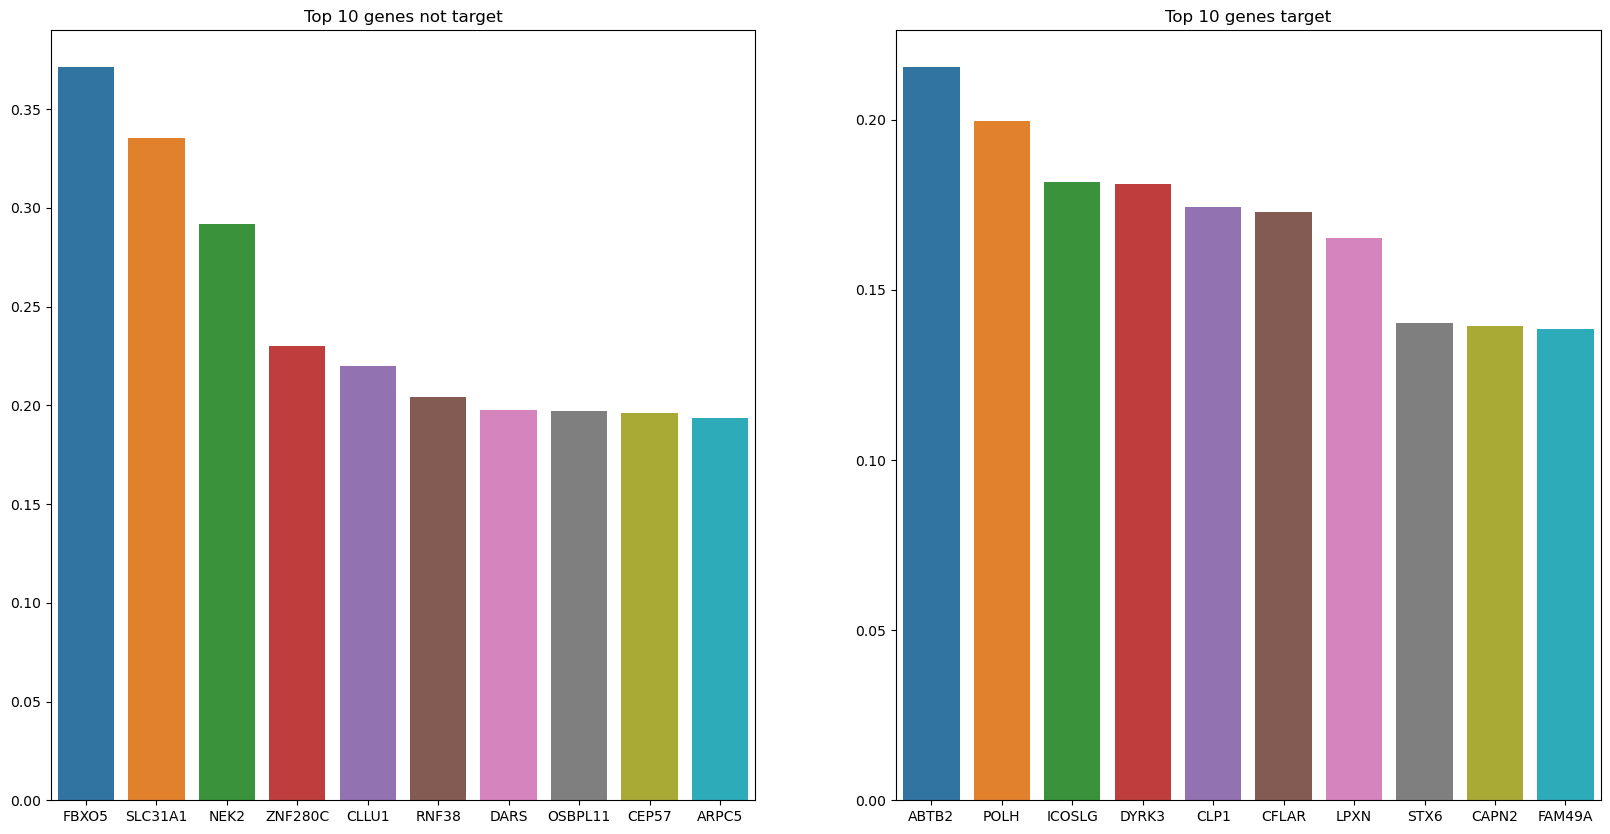

In [201]:
mod_sub_corr = mod_sub.corrwith(tp53, method='pearson')
top_10_genes_nt = mod_sub_corr.sort_values(ascending=False).head(10).index.tolist()
print("Top 10 genes not target:", top_10_genes_nt)

mod_sub_filter_corr = mod_sub_filter.corrwith(tp53, method='pearson')
top_10_genes_t = mod_sub_filter_corr.sort_values(ascending=False).head(10).index.tolist()
print("Top 10 genes target:", top_10_genes_t)


plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
sns.barplot(x=top_10_genes_nt, y=mod_sub_corr[top_10_genes_nt])
plt.title('Top 10 genes not target')
plt.subplot(1, 2, 2)
sns.barplot(x=top_10_genes_t, y=mod_sub_filter_corr[top_10_genes_t])
plt.title('Top 10 genes target')
plt.show()

In [202]:
print(f"mean of target data",abs(mod_sub_filter_corr.mean()))
print(f"mean of non target data",abs(mod_sub_corr.mean()))


mean of target data 0.05016094331398225
mean of non target data 0.009156538246132995


### The mean of target data correlation is higher, furthermore the general correlation between target and non target genes is comparable, therefore we can filter the dataset columns wit the target genes

In [203]:
mod_data = mod_data[mod_data.columns[mod_data.columns.isin(target_genes)]]

In [204]:
X_train, X_test, y_train, y_test = train_test_split(mod_data, tp53, test_size=0.2, random_state=42)

### We first try with a Logistic Regression model

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       225
           1       0.72      0.75      0.74        73

    accuracy                           0.87       298
   macro avg       0.82      0.83      0.83       298
weighted avg       0.87      0.87      0.87       298

ROC AUC Score:
0.8949162861491627


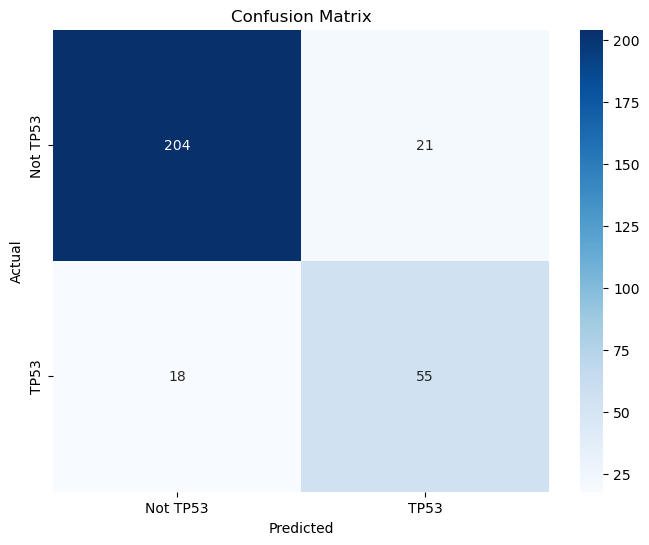

In [205]:
#fit the model
lg_model = LogisticRegression(max_iter=10000,random_state=42)
lg_model.fit(X_train, y_train)
#predict the test set
y_pred = lg_model.predict(X_test)
#predict the probabilities
y_pred_proba = lg_model.predict_proba(X_test)[:, 1]
#calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
#calculate the classification report
report = classification_report(y_test, y_pred)
#calculate the roc_auc score
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Classification Report:")
print(report)
print("ROC AUC Score:")
print(roc_auc)
# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not TP53', 'TP53'], yticklabels=['Not TP53', 'TP53'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Then we try a Random Forest classifier

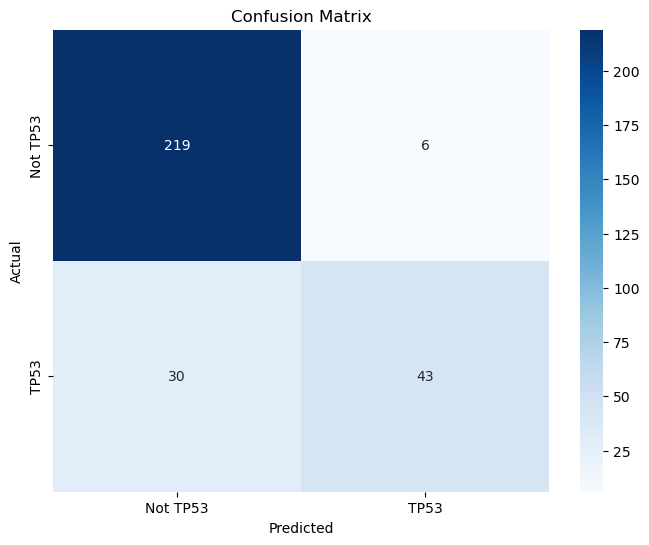

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       225
           1       0.88      0.59      0.70        73

    accuracy                           0.88       298
   macro avg       0.88      0.78      0.81       298
weighted avg       0.88      0.88      0.87       298

ROC AUC Score:
0.947945205479452


In [206]:
rf_model = RandomForestClassifier(n_estimators=200, min_samples_split=2, max_depth=10, class_weight='balanced',random_state=42)
rf_model.fit(X_train, y_train)
#predict the test set
y_pred = rf_model.predict(X_test)
#predict the probabilities
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
#calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
#calculate the classification report
report = classification_report(y_test, y_pred)
#calculate the roc_auc score
roc_auc = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not TP53', 'TP53'], yticklabels=['Not TP53', 'TP53'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print("Classification Report:")
print(report)
print("ROC AUC Score:")
print(roc_auc)

### Finally we try the XGboost model

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       225
           1       0.84      0.73      0.78        73

    accuracy                           0.90       298
   macro avg       0.88      0.84      0.86       298
weighted avg       0.90      0.90      0.90       298



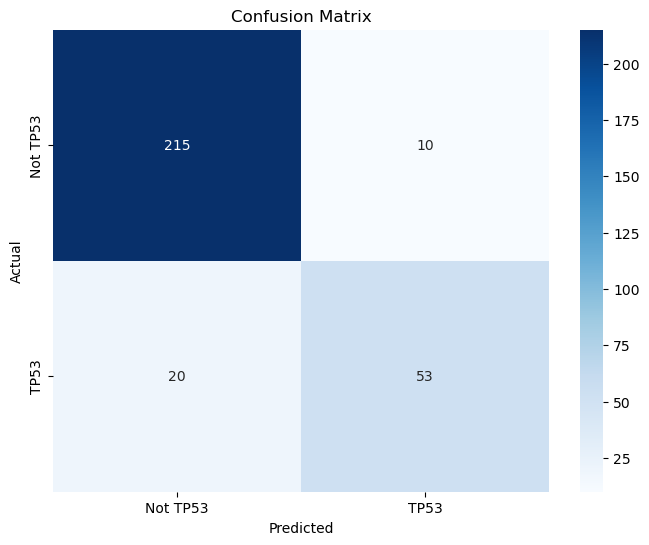

In [207]:
xgb_model = XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.1, scale_pos_weight=1,random_state=42)
xgb_model.fit(X_train, y_train)
#predict the test set
y_pred = xgb_model.predict(X_test)
#predict the probabilities
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
#calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
#calculate the classification report
report = classification_report(y_test, y_pred)
print(report)
#calculate the roc_auc score
roc_auc = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not TP53', 'TP53'], yticklabels=['Not TP53', 'TP53'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### This model's performance is the best, let's see which are the top 10 features that contributed to this result

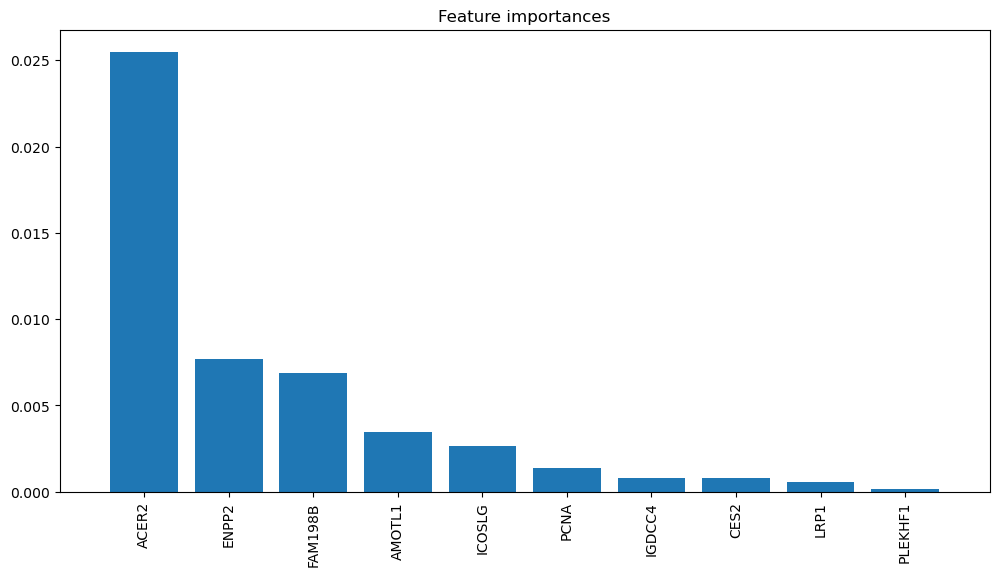

In [208]:
#feature importance
importances = (xgb_model.feature_importances_)[:10]
indices = np.argsort(importances)[::-1]
# Print the feature ranking
plt.figure(figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), X_train.columns[indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.show()

- ACER2 (dramatically highest importance): 
  Alkaline Ceramidase 2 - An enzyme involved in sphingolipid metabolism that catalyzes the hydrolysis of ceramides. Its exceptionally high importance suggests TP53 mutations may strongly affect ceramide signaling pathways, which are critical for cell death and stress responses. This relationship makes biological sense as ceramides are important mediators of apoptosis, a process tightly regulated by TP53.

- ENPP2: 
  Ectonucleotide Pyrophosphatase/Phosphodiesterase 2 - Also known as autotaxin, this enzyme produces lysophosphatidic acid (LPA), a signaling molecule that promotes cell proliferation and migration. The importance of ENPP2 suggests altered lipid signaling in TP53-mutated cancers.

- FAM158B: 
  Family with Sequence Similarity 158 Member B - Also known as TON1-regulatory protein 2 (TONSL), involved in DNA replication and repair. This connection aligns with TP53's role in genome stability.

- AMOTL1: 
  Angiomotin Like 1 - A protein that regulates cell migration and proliferation through the Hippo pathway. Its presence suggests that TP53 mutations may affect cell growth control via altered Hippo signaling.

- ICOSL/ICOSLG: 
  Inducible T-Cell Costimulator Ligand - Involved in immune response regulation. This suggests TP53 mutations may influence tumor-immune interactions.

- PCNA: 
  Proliferating Cell Nuclear Antigen - A critical protein for DNA replication and repair. TP53 directly regulates PCNA, and this relationship is well-established in cancer biology.

- IGDCC4: 
  Immunoglobulin Superfamily DCC Subclass Member 4 - Involved in cell adhesion and neural development. Its presence suggests potential alterations in cell adhesion in TP53-mutated cancers.

- CES2: 
  Carboxylesterase 2 - An enzyme involved in drug metabolism. This may indicate altered drug response pathways in TP53-mutated tumors.

- LRP1: 
  A multifunctional receptor involved in lipoprotein metabolism and cellular signaling, demonstrates important connections  with TP53 by modulating pathways that influence tumor invasion and stress responses. 

- PLEKHF1: 
  Pleckstrin Homology And FYVE Domain Containing 1 - A protein involved in endosome function and apoptosis. Its presence further supports the connection between TP53 mutations and altered cell death pathways.

Biological interpretation of this plot:

The dramatic prominence of ACER2 compared to other features suggests ceramide metabolism may be a key distinguishing characteristic of TP53-mutated cancers in your TCGA dataset. This points to altered stress response and cell death mechanisms.
The plot reveals multiple affected pathways:

Lipid signaling (ACER2, ENPP2, LPP1)
DNA repair/replication (FAM158B/TONSL, PCNA)
Cell growth control (AMOTL1)
Immune interactions (ICOSL)
Cell adhesion (IGDCC4)


This diversity reflects TP53's role as a master regulator affecting multiple cellular systems, but the model suggests lipid metabolism, may be especially affected in this TCGA dataset.